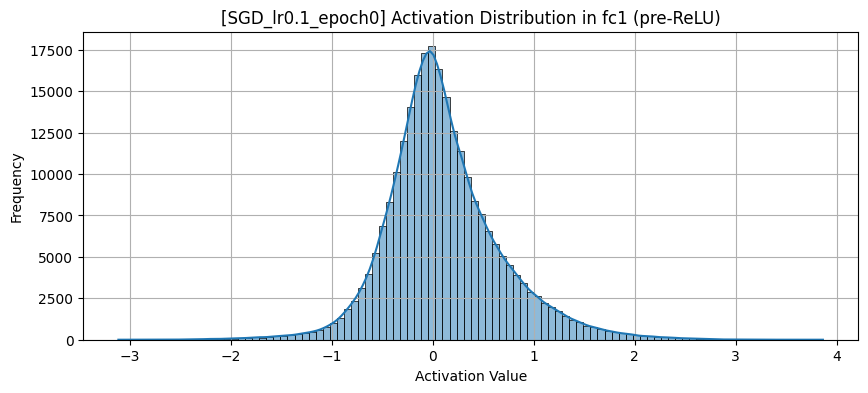

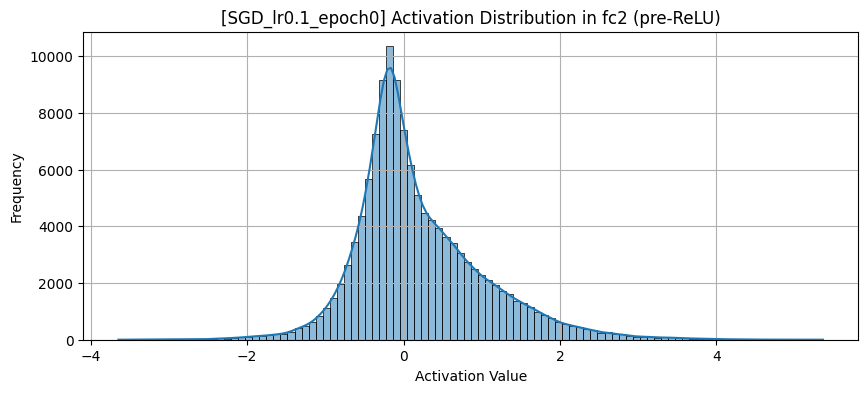

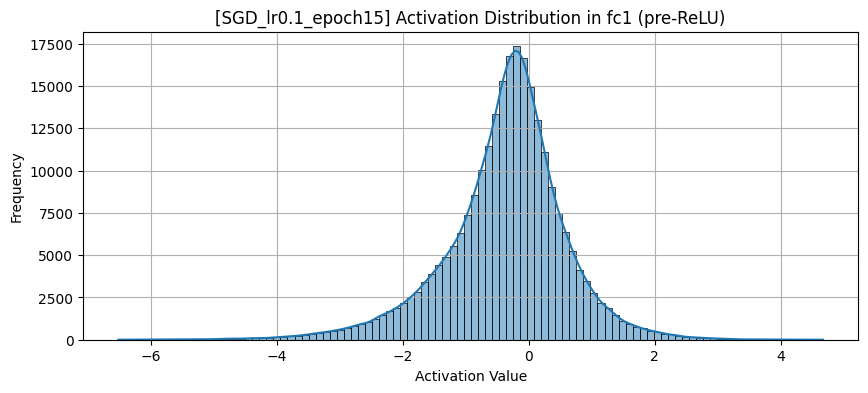

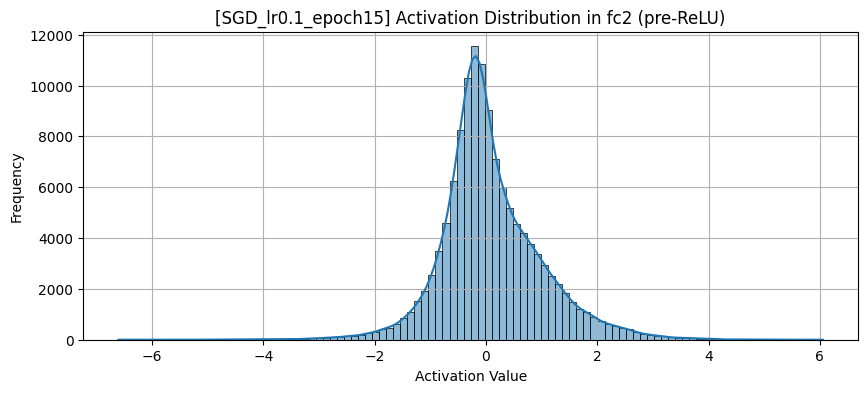

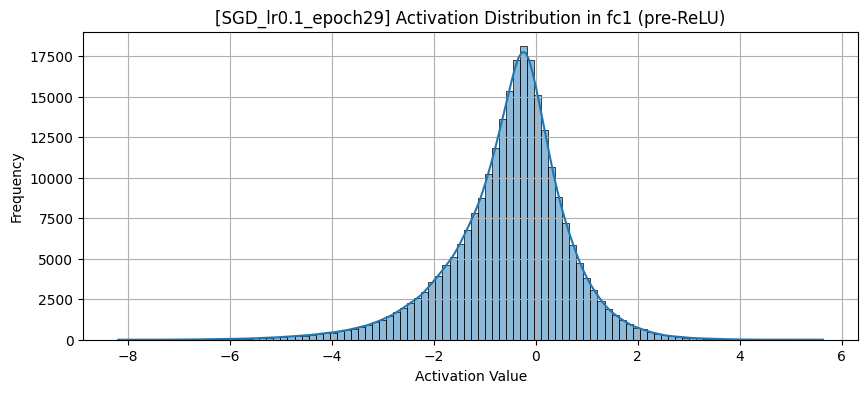

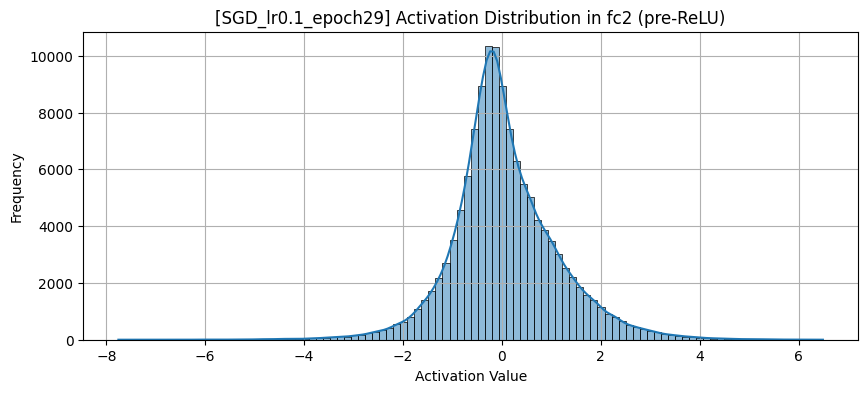

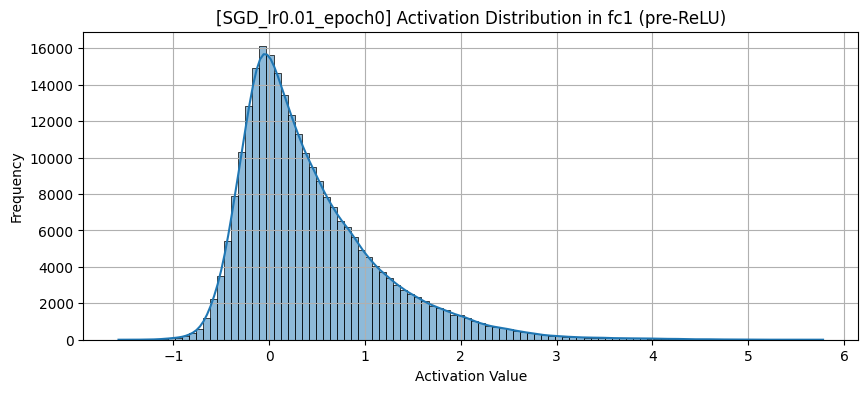

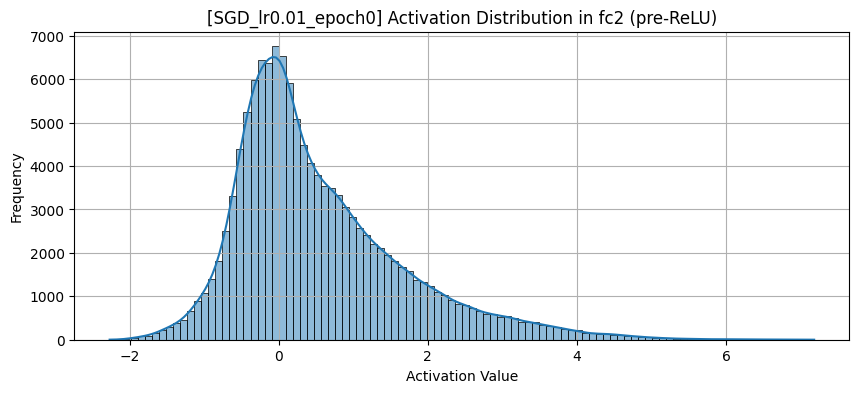

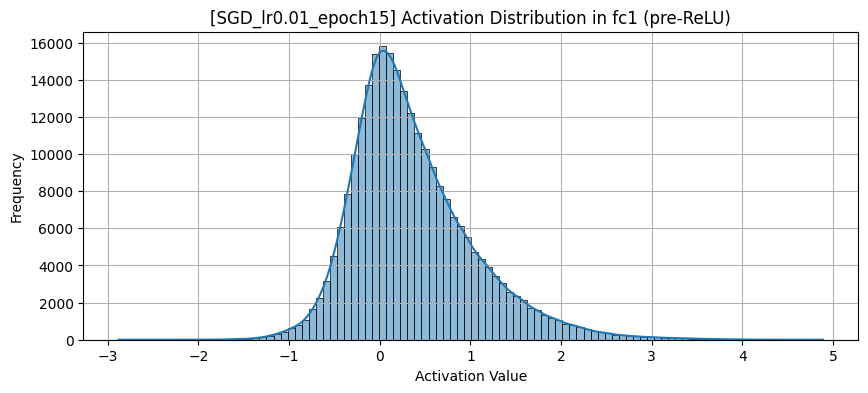

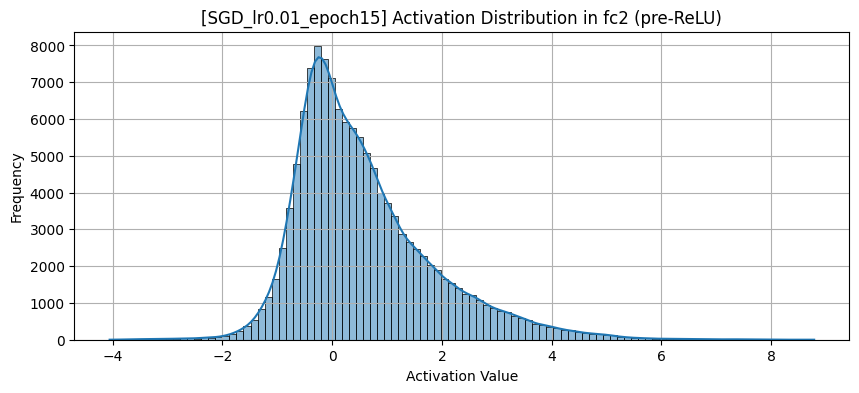

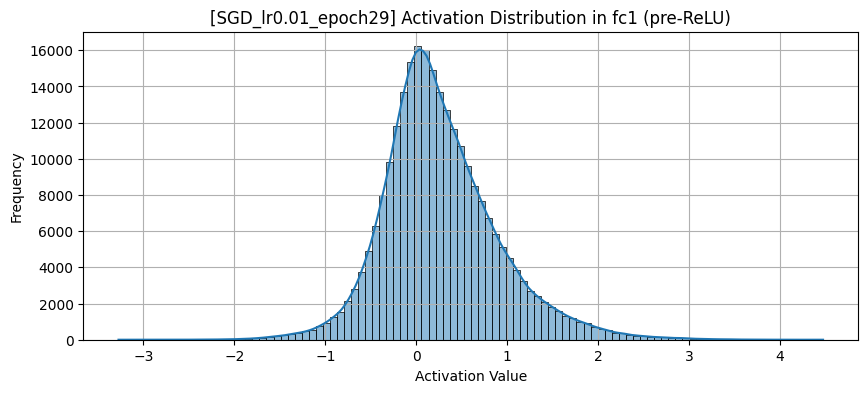

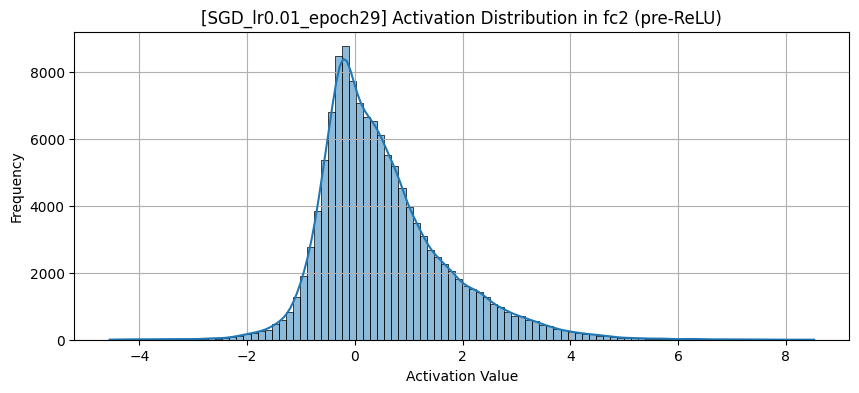

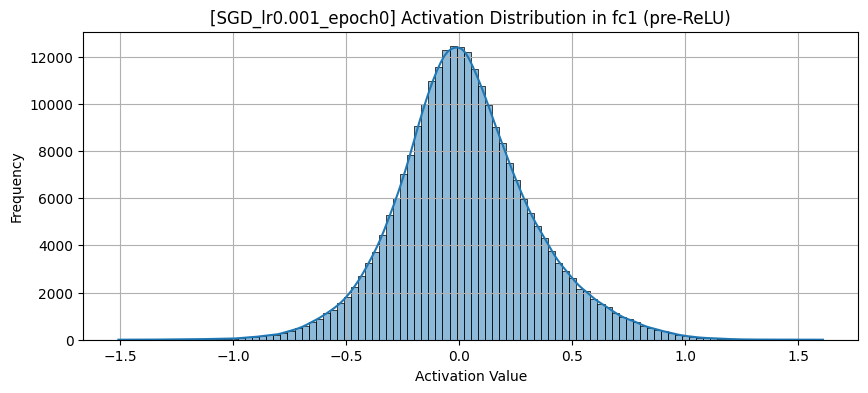

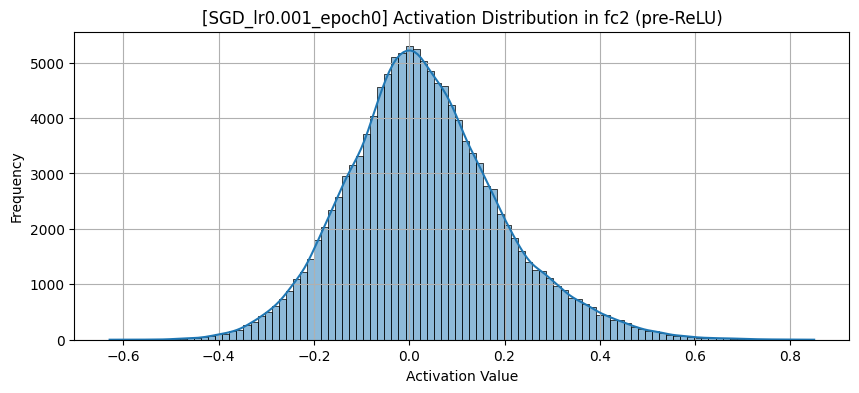

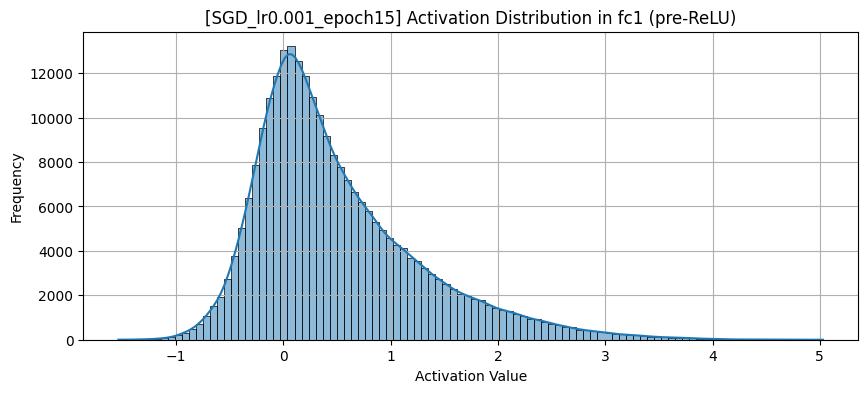

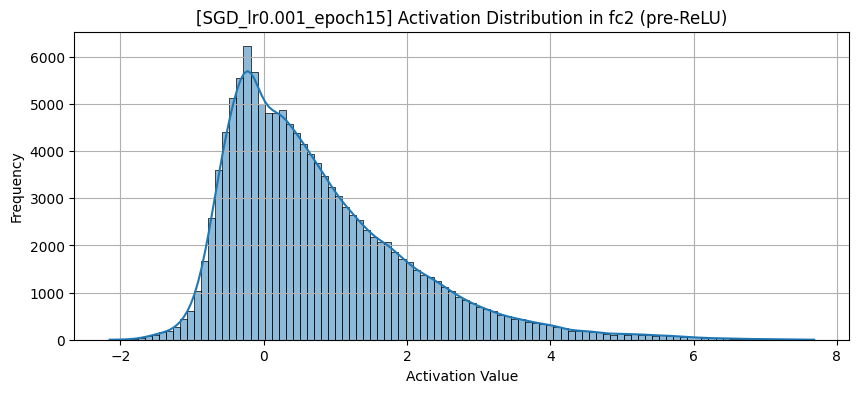

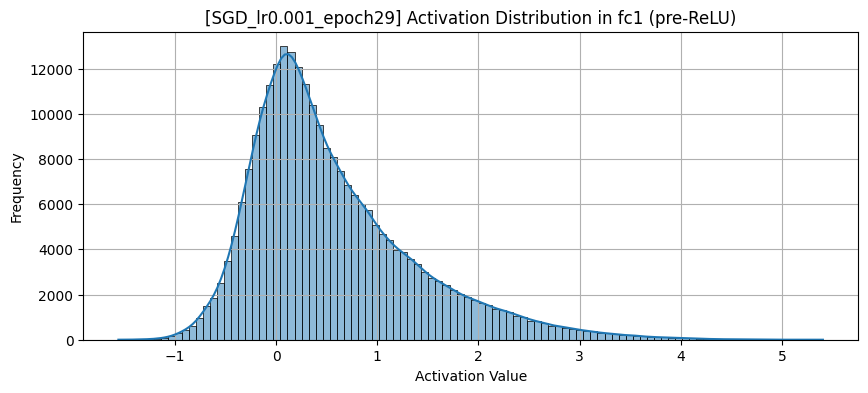

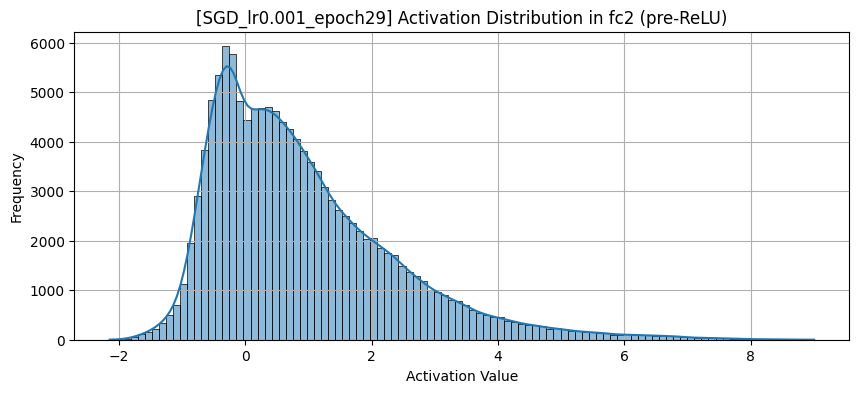

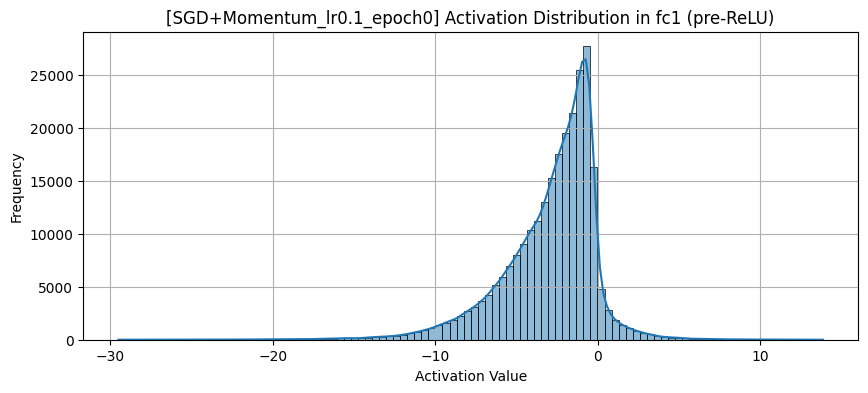

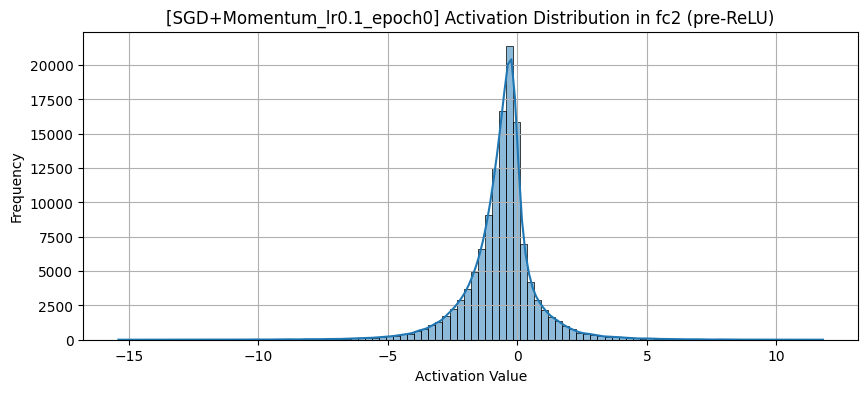

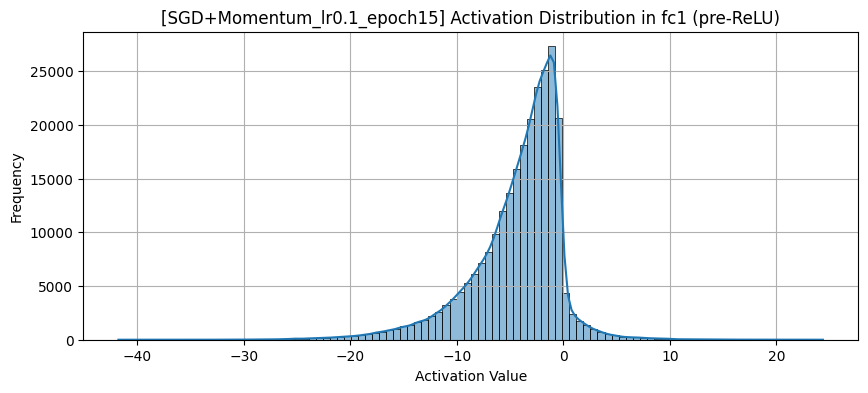

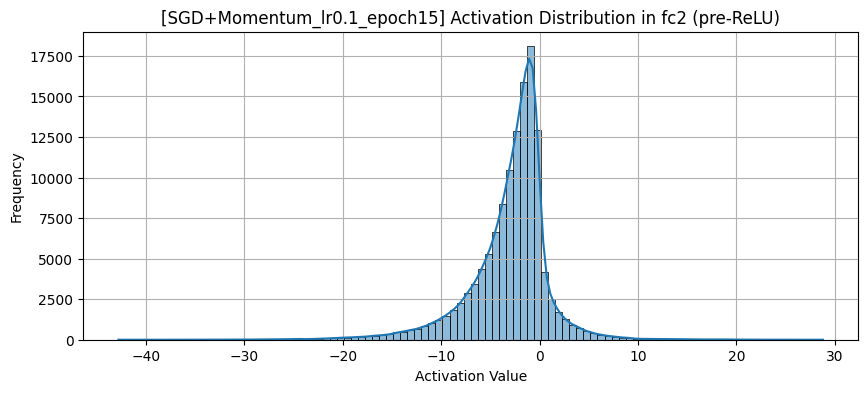

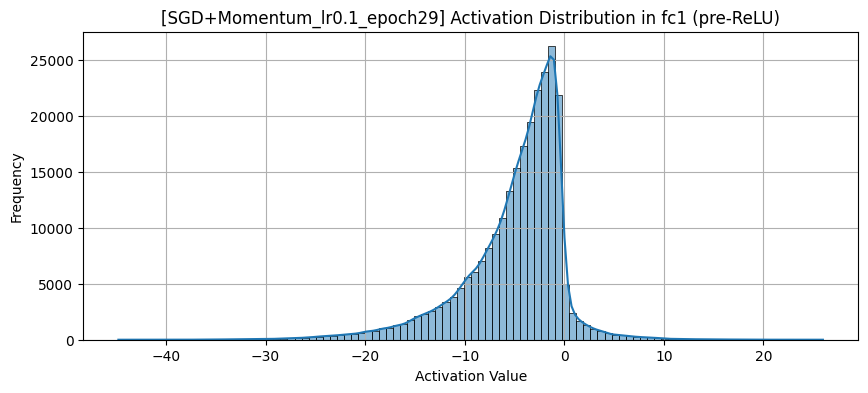

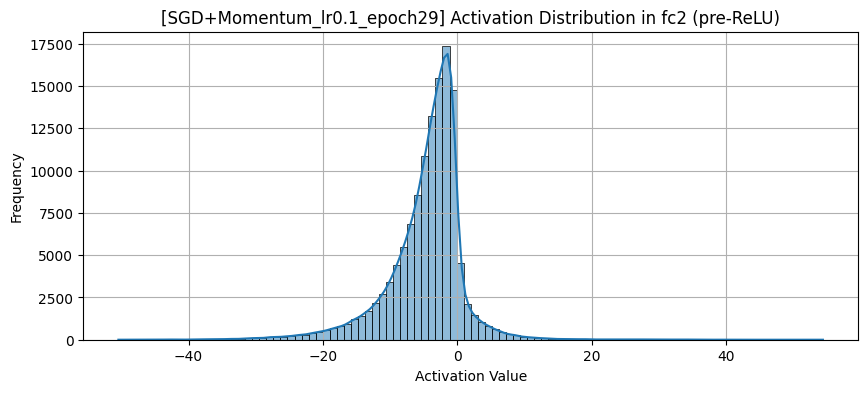

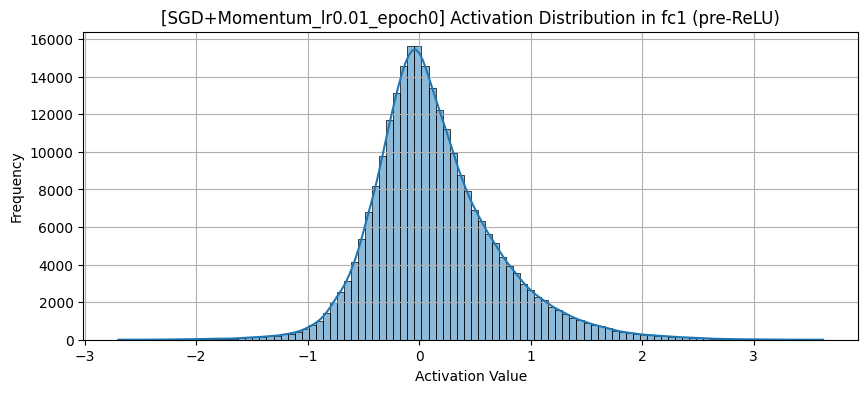

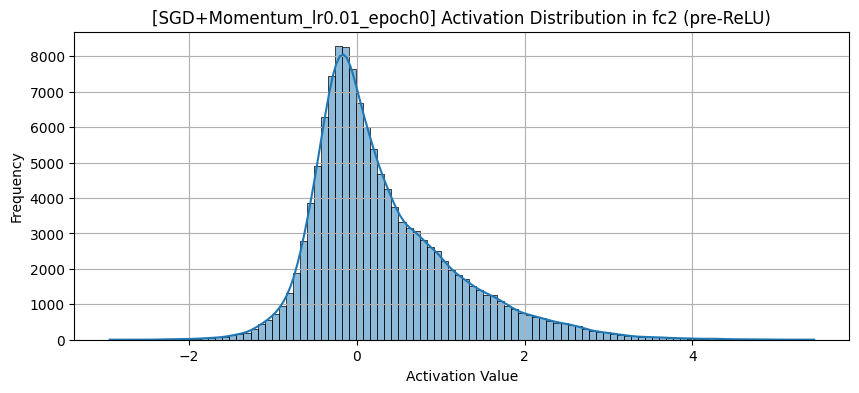

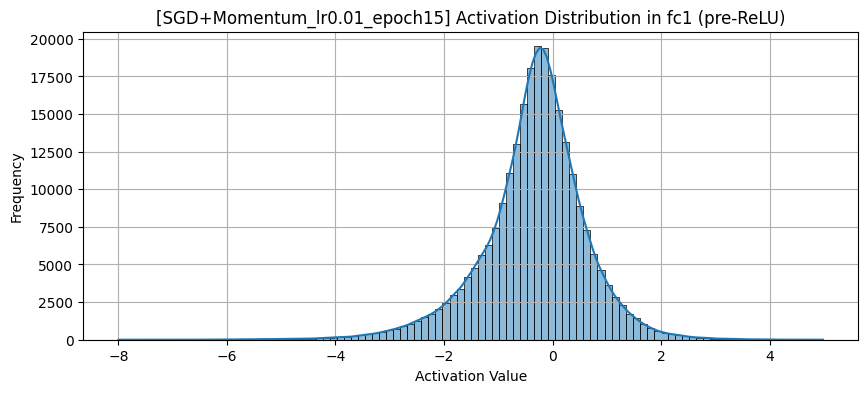

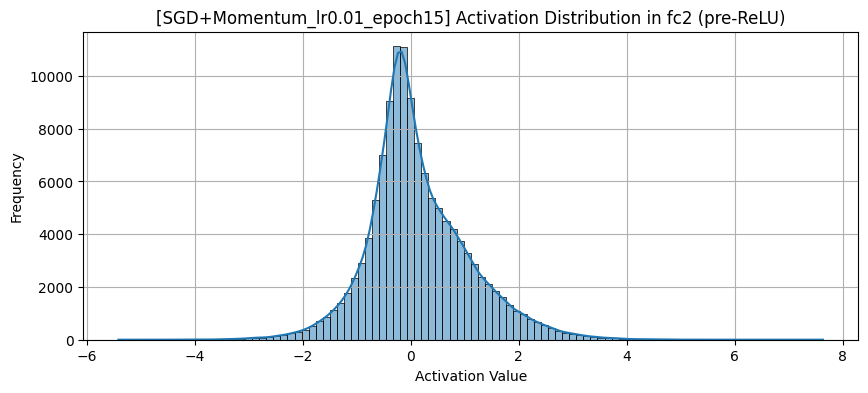

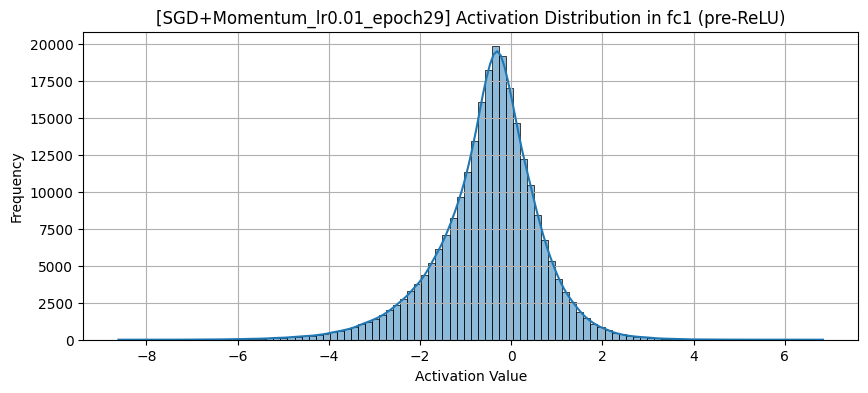

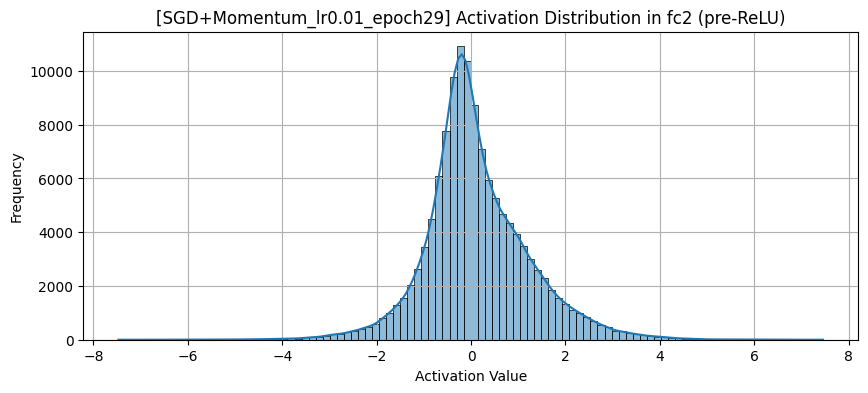

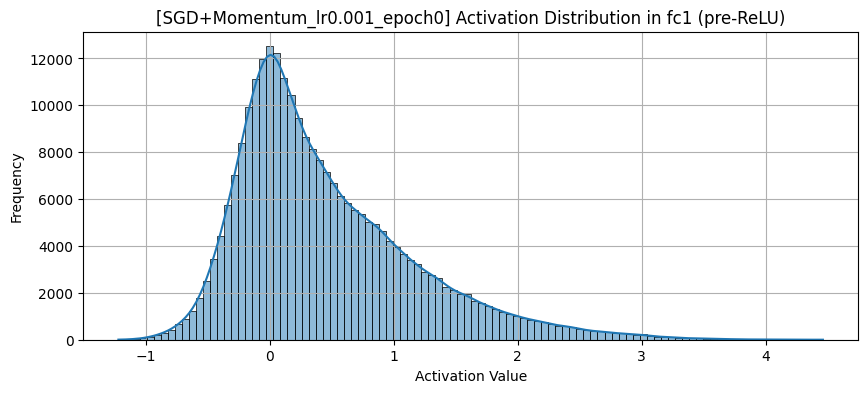

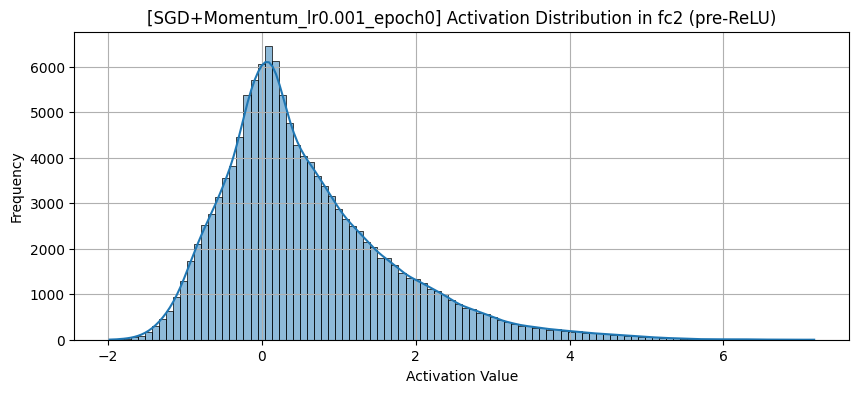

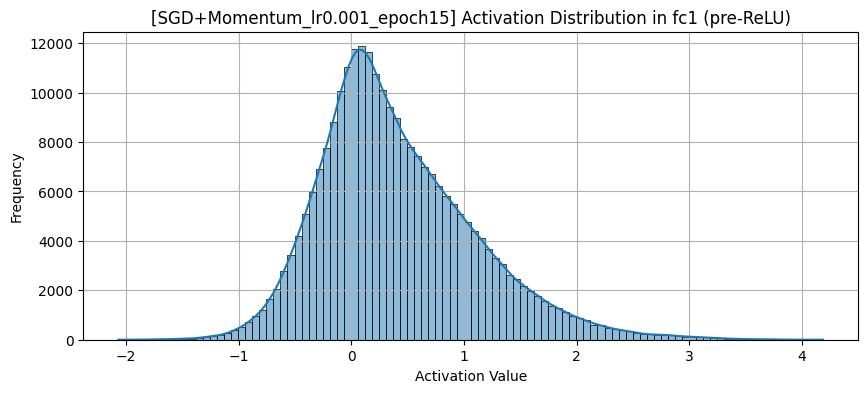

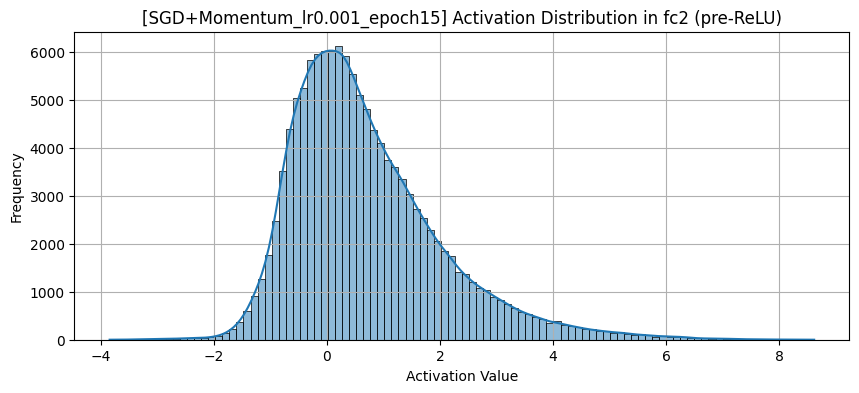

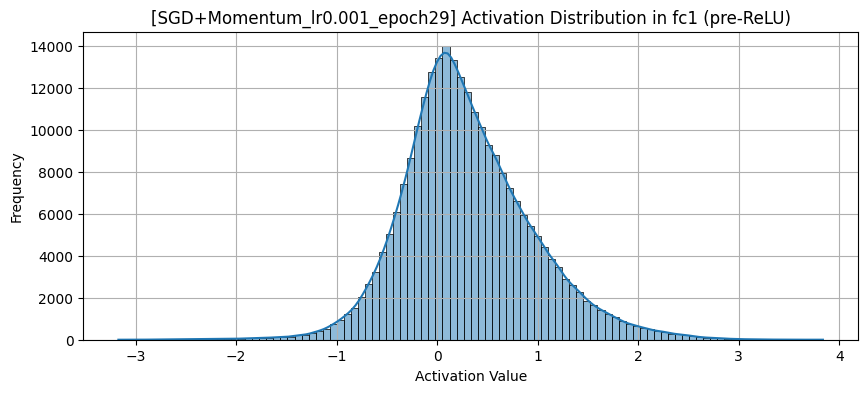

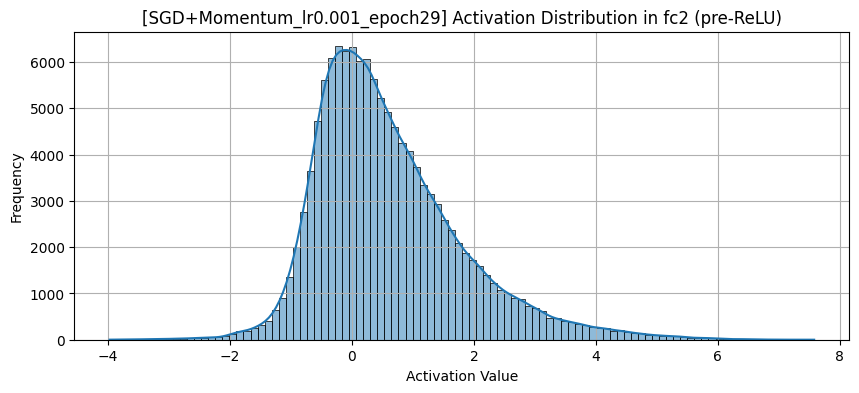

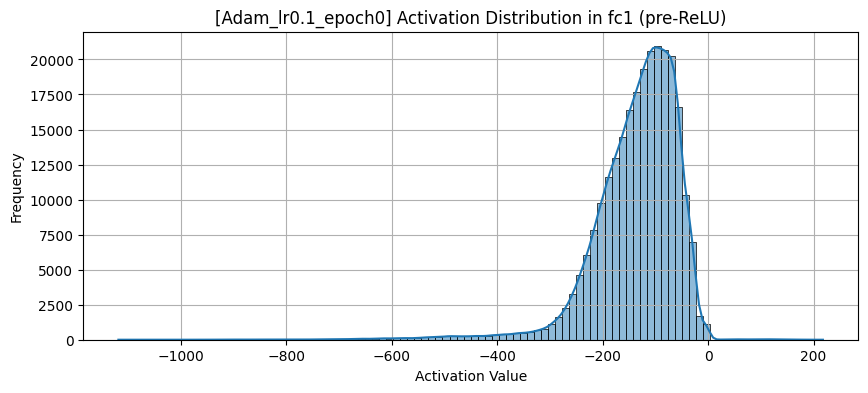

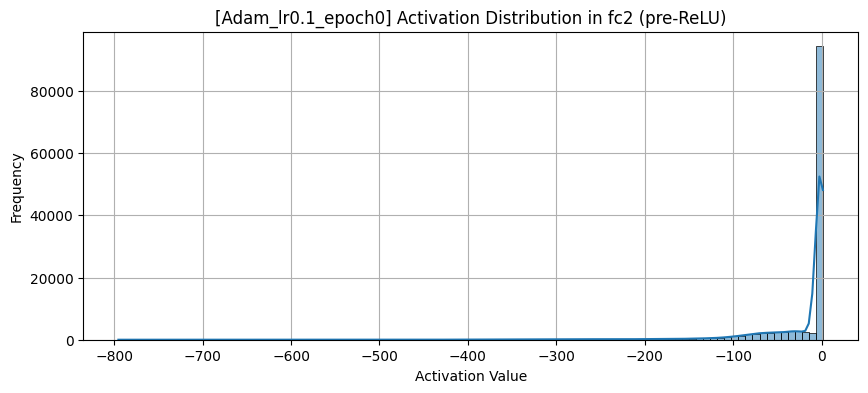

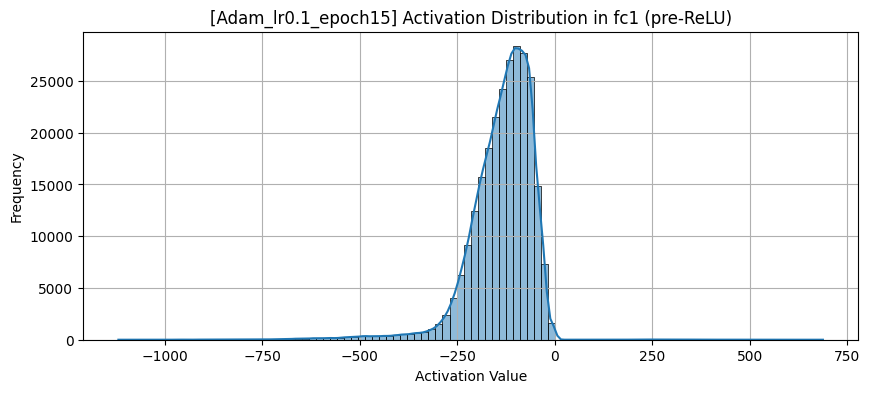

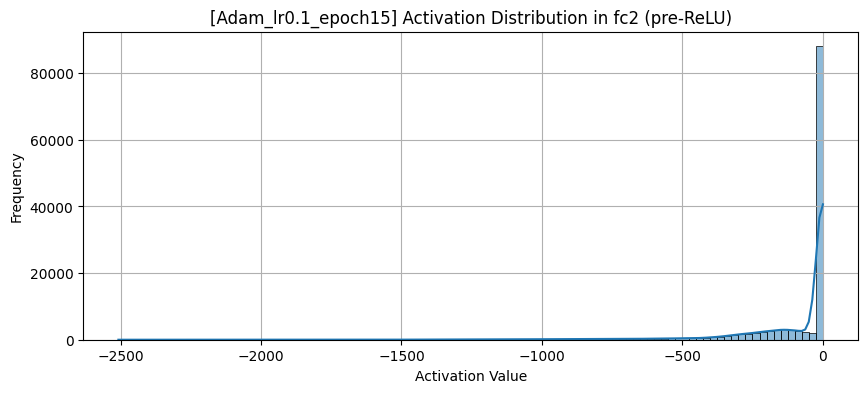

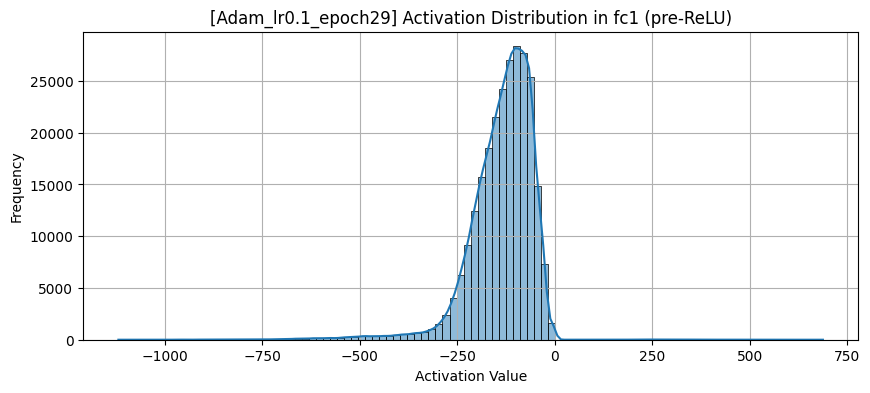

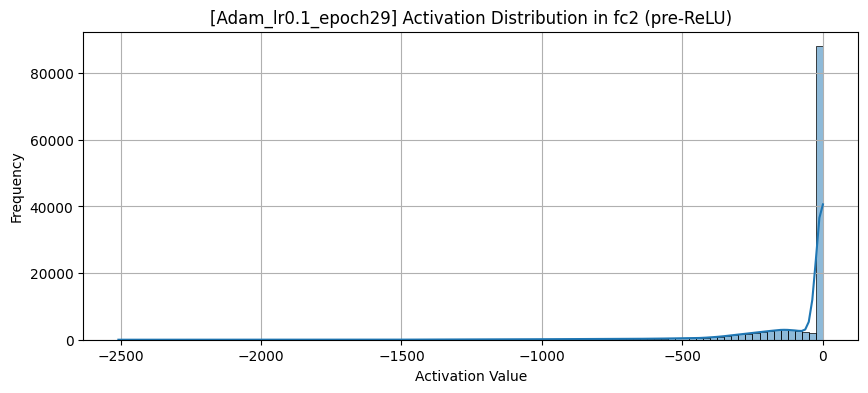

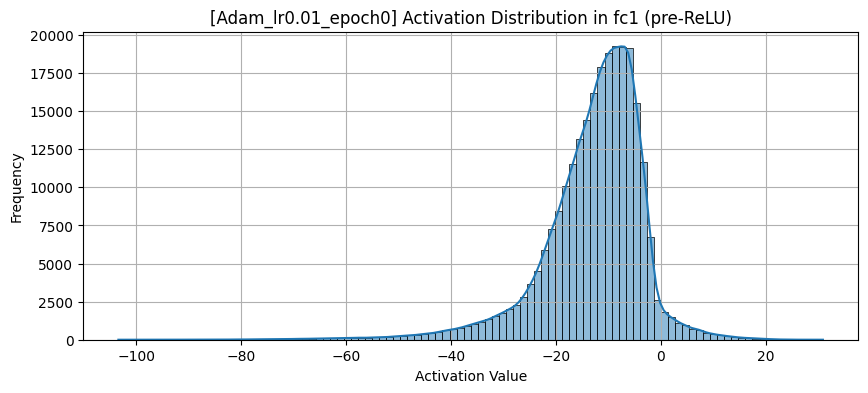

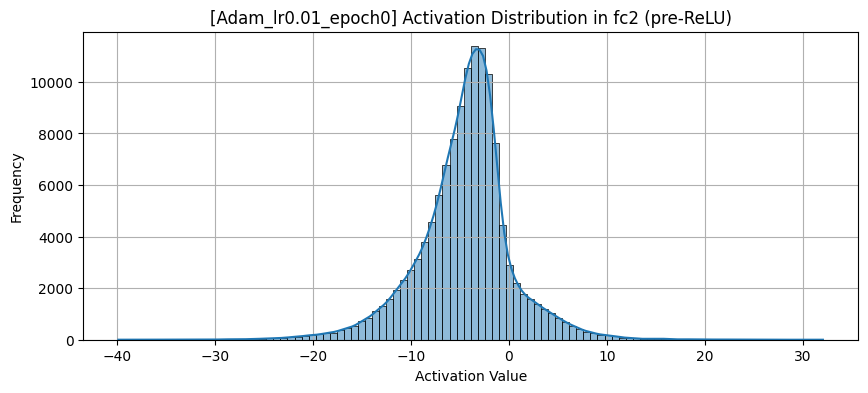

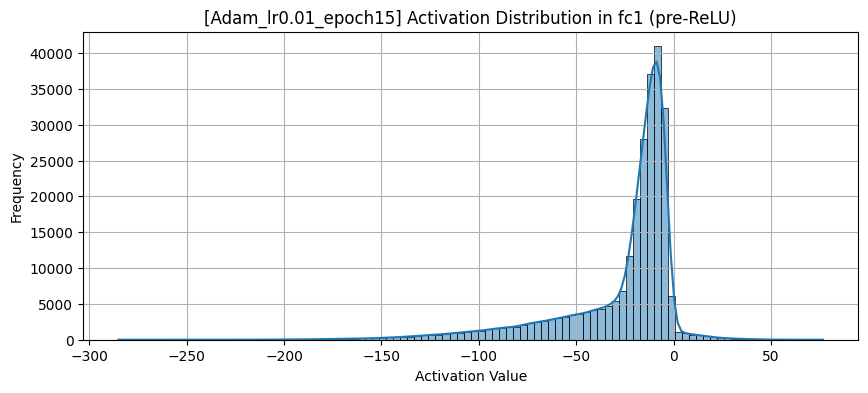

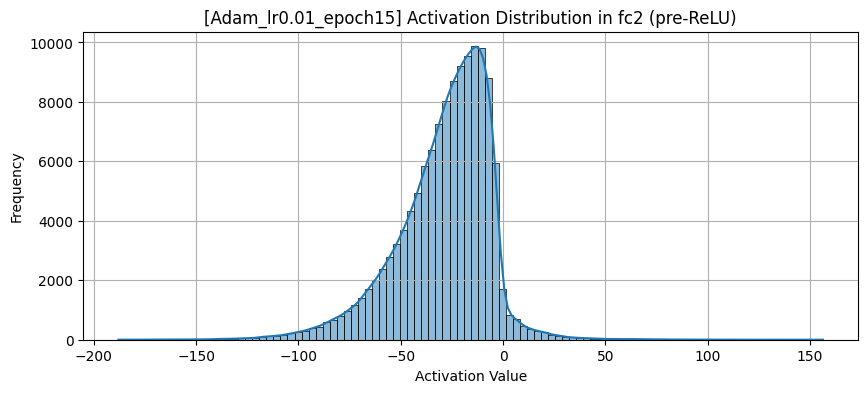

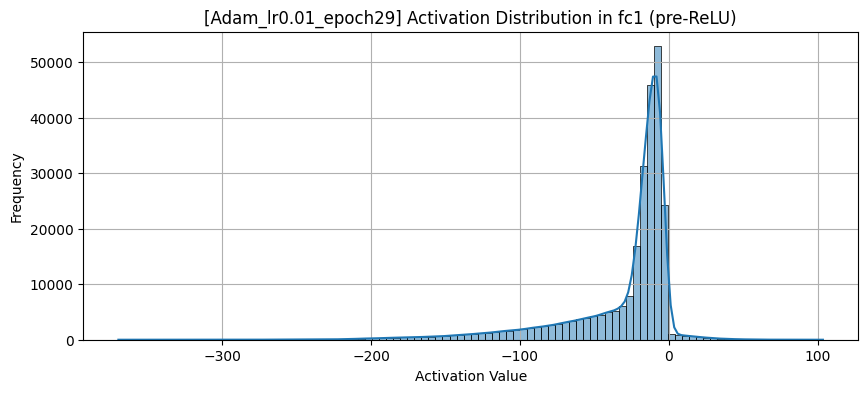

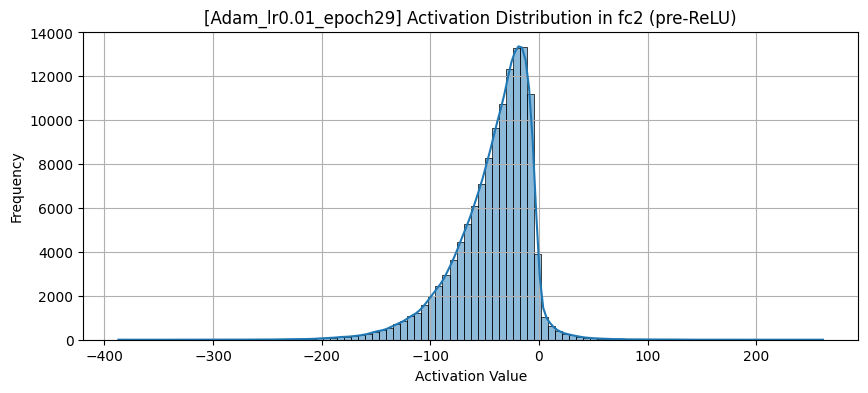

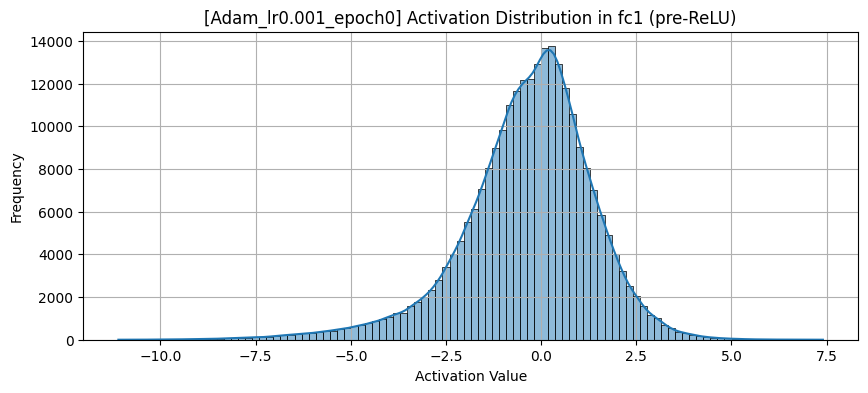

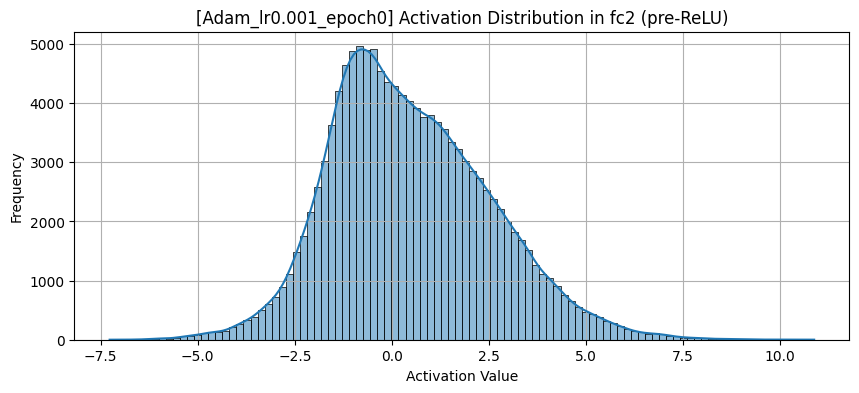

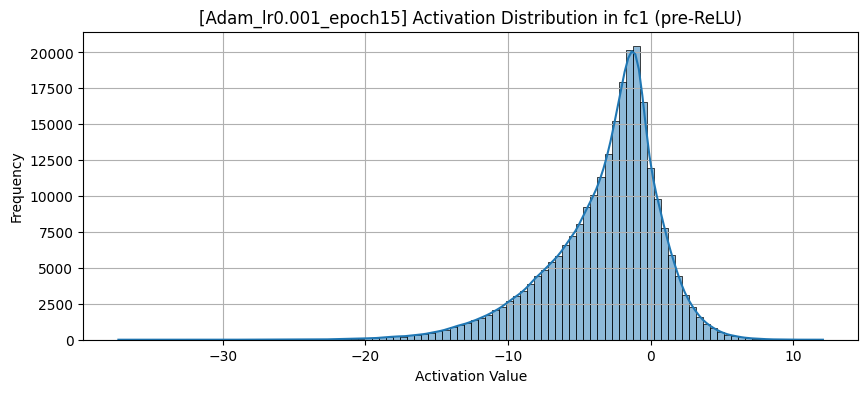

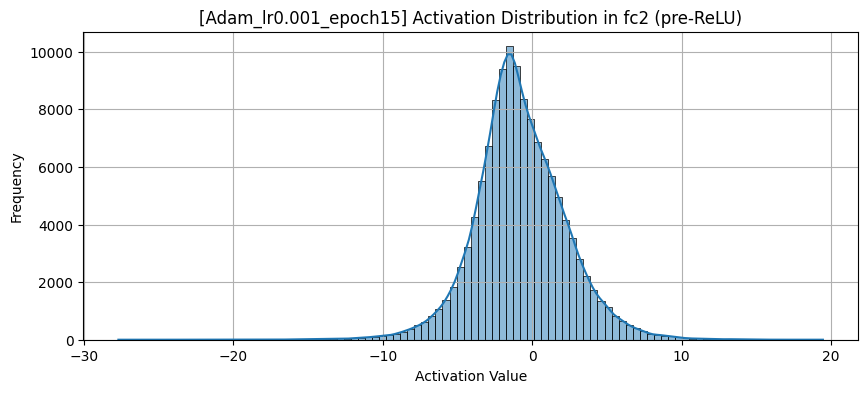

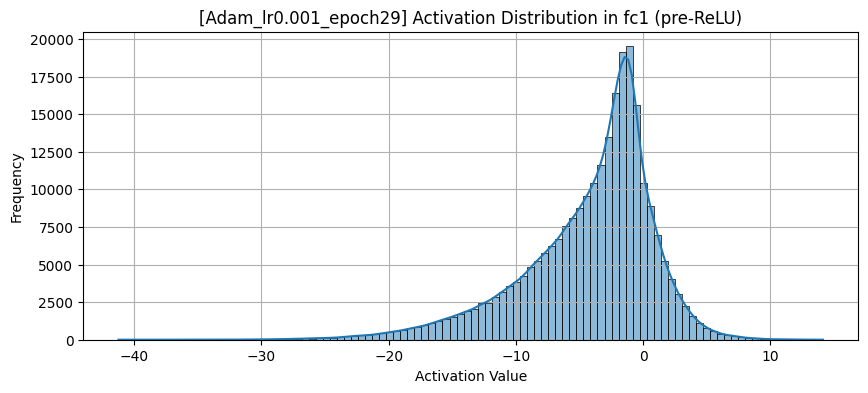

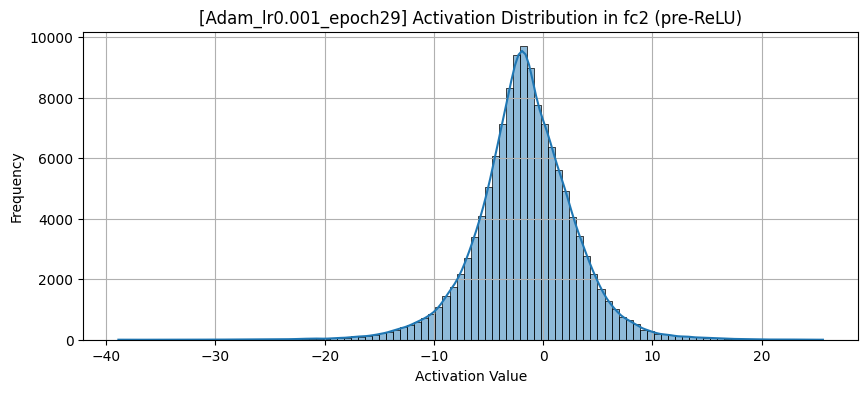

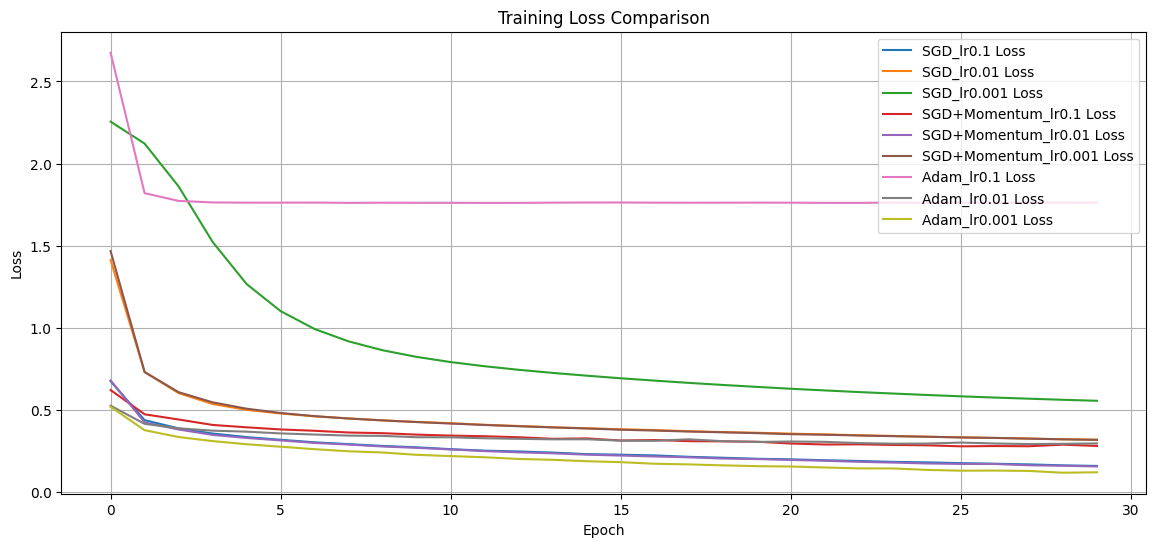

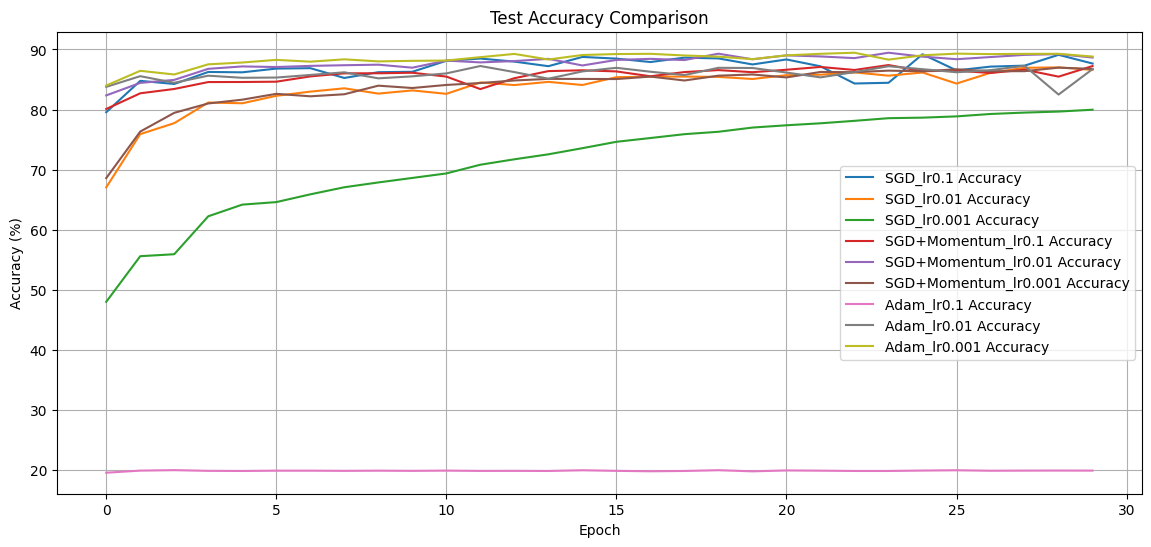

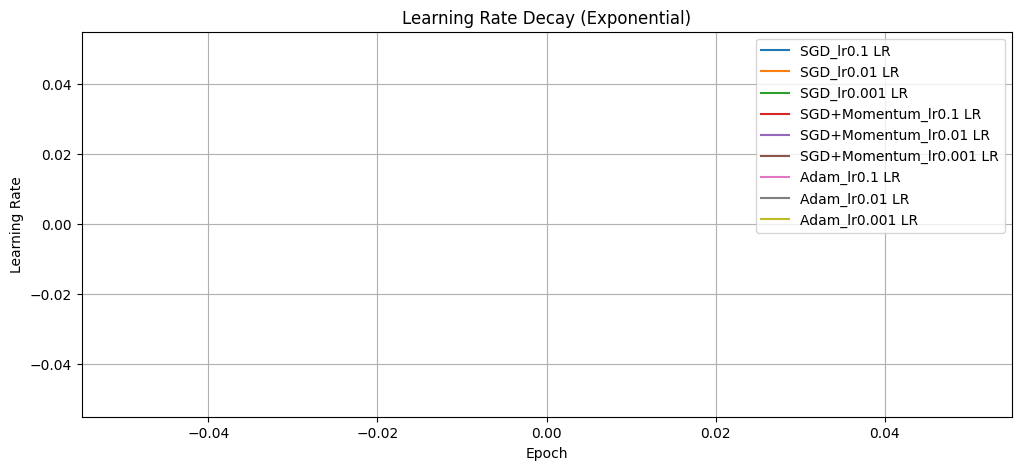

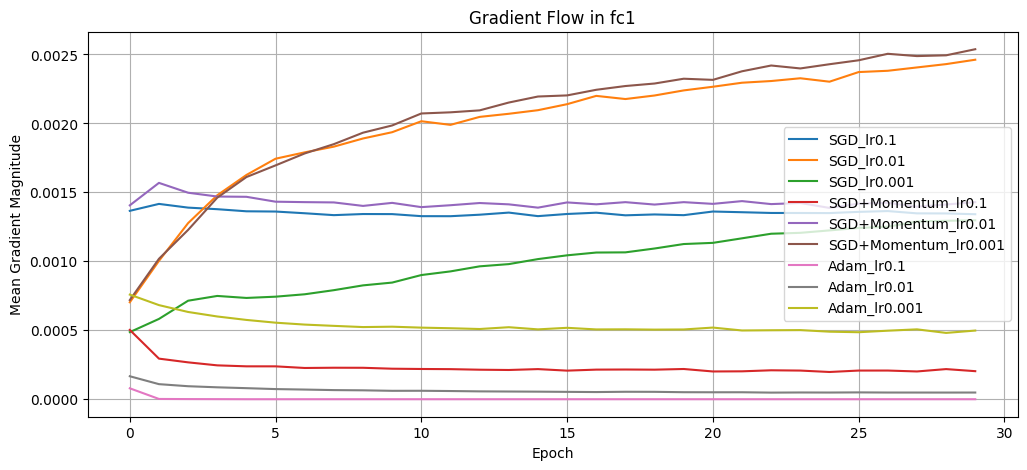

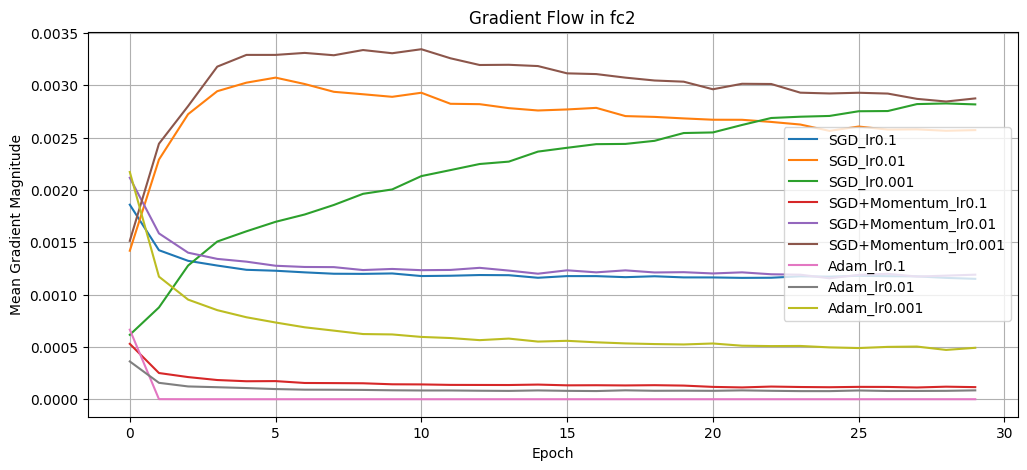

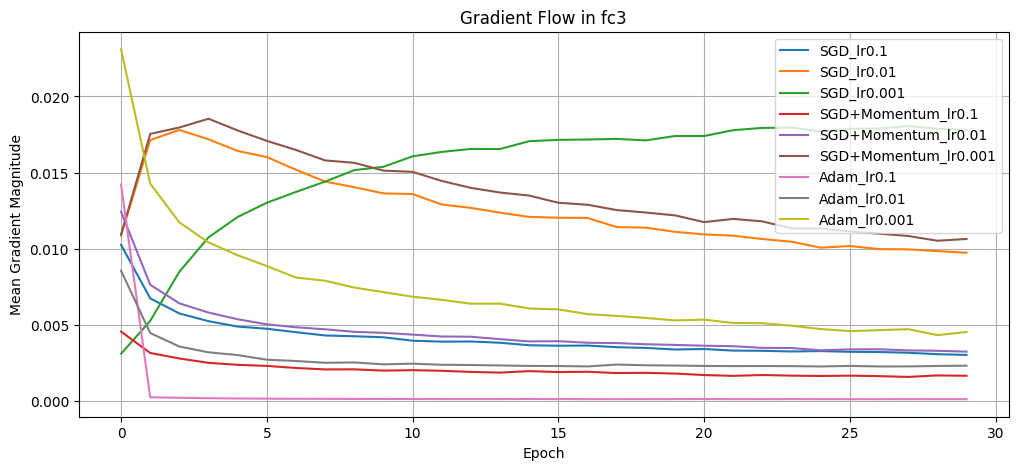


=== 실험 C 정량 비교표 ===
      Optimizer (lr)  최종 정확도 (%)  Loss 최솟값  수렴까지 걸린 epoch 수
           SGD_lr0.1       87.65    0.1578               30
          SGD_lr0.01       86.60    0.3178               30
         SGD_lr0.001       79.97    0.5546               30
  SGD+Momentum_lr0.1       87.24    0.2773               26
 SGD+Momentum_lr0.01       88.65    0.1545               30
SGD+Momentum_lr0.001       86.75    0.3167               30
          Adam_lr0.1       19.93    1.7602               12
         Adam_lr0.01       86.73    0.2912               28
        Adam_lr0.001       88.81    0.1165               29


'\n\n=== 실험 C 정량 비교표 ===\n      Optimizer (lr)  최종 정확도 (%)  Loss 최솟값  수렴까지 걸린 epoch 수\n           SGD_lr0.1       89.12    0.1928               30\n          SGD_lr0.01       84.03    0.4099               30\n         SGD_lr0.001       68.46    0.8361               30\n  SGD+Momentum_lr0.1       89.19    0.1564               30\n SGD+Momentum_lr0.01       89.17    0.1917               30\nSGD+Momentum_lr0.001       84.32    0.4131               30\n          Adam_lr0.1       58.74    0.9911               30\n         Adam_lr0.01       88.37    0.1865               30\n        Adam_lr0.001       90.15    0.1081               30\n'

In [4]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. 모델 정의 
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x, return_activations=False):
        a1 = self.fc1(x)
        h1 = self.relu1(a1)
        a2 = self.fc2(h1)
        h2 = self.relu2(a2)
        out = self.fc3(h2)
        if return_activations:
            return out, a1, a2
        return out

# 2. 학습 함수 (Schedular o)
"""
def train(model, optimizer, scheduler, loss_fn, dataloader):
    model.train()
    total_loss, correct = 0.0, 0
    grads = []

    for X, y in dataloader:
        X, y = X.view(X.size(0), -1).to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()

        grad_means = []
        for name, param in model.named_parameters():
            if 'weight' in name and param.grad is not None:
                grad_means.append(param.grad.detach().abs().mean().item())
        grads.append(grad_means)

        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(y).sum().item()

    scheduler.step()
    return total_loss / len(dataloader), correct / len(dataloader.dataset), np.mean(grads, axis=0).tolist()
"""

# 2. 학습 함수 (Schedular x)
def train(model, optimizer, loss_fn, dataloader):
    model.train()
    total_loss, correct = 0.0, 0
    grads = []

    for X, y in dataloader:
        X, y = X.view(X.size(0), -1).to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()

        grad_means = []
        for name, param in model.named_parameters():
            if 'weight' in name and param.grad is not None:
                grad_means.append(param.grad.detach().abs().mean().item())
        grads.append(grad_means)

        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(y).sum().item()

    # scheduler.step()
    return total_loss / len(dataloader), correct / len(dataloader.dataset), np.mean(grads, axis=0).tolist()


# 3. 테스트 함수
def test(model, loss_fn, dataloader):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.view(X.size(0), -1).to(device), y.to(device)
            output = model(X)
            loss = loss_fn(output, y)
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(y).sum().item()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)

# 4. Activation 시각화 함수
def visualize_activations(model, dataloader, stage=""):
    model.eval()
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.view(X.size(0), -1).to(device)
            _, a1, a2 = model(X, return_activations=True)
            a1 = a1.cpu().numpy().flatten()
            a2 = a2.cpu().numpy().flatten()
            break

    plt.figure(figsize=(10, 4))
    sns.histplot(a1, bins=100, kde=True)
    plt.title(f"[{stage}] Activation Distribution in fc1 (pre-ReLU)")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.histplot(a2, bins=100, kde=True)
    plt.title(f"[{stage}] Activation Distribution in fc2 (pre-ReLU)")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# 5. 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 30
learning_rates = [0.1, 0.01, 0.001]
optimizers = ['SGD', 'SGD+Momentum', 'Adam']

# 6. 데이터셋
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)

results = {}

# 7. 실험 (Schedular o)
"""
for opt_name in optimizers:
    for lr in learning_rates:
        model = MLP(28*28, 10).to(device)
        loss_fn = nn.CrossEntropyLoss()

        if opt_name == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        elif opt_name == 'SGD+Momentum':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        elif opt_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train_losses, test_accuracies, lrs = [], [], []
        gradient_flows = []

        for epoch in range(epochs):
            train_loss, train_acc, grads = train(model, optimizer, scheduler, loss_fn, train_loader)
            test_loss, test_acc = test(model, loss_fn, test_loader)

            train_losses.append(train_loss)
            test_accuracies.append(test_acc)
            gradient_flows.append(grads)
            lrs.append(scheduler.get_last_lr()[0])

            if epoch in [0, 15, 29]:
                stage = f"{opt_name}_lr{lr}_epoch{epoch}"
                visualize_activations(model, test_loader, stage)

        key = f"{opt_name}_lr{lr}"
        results[key] = {
            "losses": train_losses,
            "accuracies": test_accuracies,
            "gradients": gradient_flows,
            "lrs": lrs
        }
"""

# 7. 실험 (Schedular x)
for opt_name in optimizers:
    for lr in learning_rates:
        model = MLP(28*28, 10).to(device)
        loss_fn = nn.CrossEntropyLoss()

        if opt_name == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        elif opt_name == 'SGD+Momentum':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        elif opt_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train_losses, test_accuracies, lrs = [], [], []
        gradient_flows = []

        for epoch in range(epochs):
            train_loss, train_acc, grads = train(model, optimizer, loss_fn, train_loader)
            test_loss, test_acc = test(model, loss_fn, test_loader)

            train_losses.append(train_loss)
            test_accuracies.append(test_acc)
            gradient_flows.append(grads)
            # lrs.append(scheduler.get_last_lr()[0])

            if epoch in [0, 15, 29]:
                stage = f"{opt_name}_lr{lr}_epoch{epoch}"
                visualize_activations(model, test_loader, stage)

        key = f"{opt_name}_lr{lr}"
        results[key] = {
            "losses": train_losses,
            "accuracies": test_accuracies,
            "gradients": gradient_flows,
            "lrs": lrs
        }

# 8. 결과 시각화
# 8-1. loss
plt.figure(figsize=(14,6))
for key, res in results.items():
    plt.plot(res["losses"], label=f"{key} Loss")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 8-2. Accuracy
plt.figure(figsize=(14,6))
for key, res in results.items():
    plt.plot([acc*100 for acc in res["accuracies"]], label=f"{key} Accuracy")
plt.title("Test Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

# 8-3. Learning rate decay
plt.figure(figsize=(12,5))
for key, res in results.items():
    plt.plot(res["lrs"], label=f"{key} LR")
plt.title("Learning Rate Decay (Exponential)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.grid(True)
plt.show()

# 8-4. Gradient flow
layers = ['fc1', 'fc2', 'fc3']
for i, layer in enumerate(layers):
    plt.figure(figsize=(12,5))
    for key in results:
        grads = [g[i] for g in results[key]["gradients"]]
        plt.plot(grads, label=f"{key}")
    plt.title(f"Gradient Flow in {layer}")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Gradient Magnitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# 9. 정량 비교표
comparison_df = pd.DataFrame({
    "Optimizer (lr)": [],
    "최종 정확도 (%)": [],
    "Loss 최솟값": [],
    "수렴까지 걸린 epoch 수": []
})

for key, res in results.items():
    final_acc = round(res["accuracies"][-1] * 100, 2)
    min_loss = round(min(res["losses"]), 4)
    converge_epoch = np.argmin(res["losses"]) + 1
    comparison_df.loc[len(comparison_df)] = [key, final_acc, min_loss, converge_epoch]

print("\n=== 실험 C 정량 비교표 ===")
print(comparison_df.to_string(index=False))

"""

=== 실험 C 정량 비교표(Schedular o) ===
      Optimizer (lr)  최종 정확도 (%)  Loss 최솟값  수렴까지 걸린 epoch 수
           SGD_lr0.1       89.12    0.1928               30
          SGD_lr0.01       84.03    0.4099               30
         SGD_lr0.001       68.46    0.8361               30
  SGD+Momentum_lr0.1       89.19    0.1564               30
 SGD+Momentum_lr0.01       89.17    0.1917               30
SGD+Momentum_lr0.001       84.32    0.4131               30
          Adam_lr0.1       58.74    0.9911               30
         Adam_lr0.01       88.37    0.1865               30
        Adam_lr0.001       90.15    0.1081               30


=== 실험 C 정량 비교표(Schedular x) ===
      Optimizer (lr)  최종 정확도 (%)  Loss 최솟값  수렴까지 걸린 epoch 수
           SGD_lr0.1       87.65    0.1578               30
          SGD_lr0.01       86.60    0.3178               30
         SGD_lr0.001       79.97    0.5546               30
  SGD+Momentum_lr0.1       87.24    0.2773               26
 SGD+Momentum_lr0.01       88.65    0.1545               30
SGD+Momentum_lr0.001       86.75    0.3167               30
          Adam_lr0.1       19.93    1.7602               12
         Adam_lr0.01       86.73    0.2912               28
        Adam_lr0.001       88.81    0.1165               29
"""